In [48]:
import pandas as pd
import numpy as np
import random
from PIL import Image

import keras
import tensorflow
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import time
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


os.listdir()

['.ipynb_checkpoints',
 'Audacity',
 'base_dir',
 'data_records_27638.txt',
 'desktop.ini',
 'faulty_images.txt',
 'final-dataset-yummly.zip',
 'flavours.csv',
 'images27638',
 'images27638.zip',
 'metadata27368.csv',
 'mobilenet-training-and-exporting.ipynb',
 'model.h5',
 'protos',
 'protos.zip']

### Create the directory structure
In these folders we will store the images that will later be fed to the Keras generators.

In [49]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # Meaty
    # Sweet
    # Piquant
    # Sour
    # Salty
    # Bitter
 
# val_dir
    # Meaty
    # Sweet
    # Piquant
    # Sour
    # Salty
    # Bitter

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
meaty = os.path.join(train_dir, 'Meaty')
os.mkdir(meaty)
sweet = os.path.join(train_dir, 'Sweet')
os.mkdir(sweet)
piq = os.path.join(train_dir, 'Piquant')
os.mkdir(piq)
sour = os.path.join(train_dir, 'Sour')
os.mkdir(sour)
salty = os.path.join(train_dir, 'Salty')
os.mkdir(salty)
bitter = os.path.join(train_dir, 'Bitter')
os.mkdir(bitter)



# create new folders inside val_dir
meaty = os.path.join(val_dir, 'Meaty')
os.mkdir(meaty)
sweet = os.path.join(val_dir, 'Sweet')
os.mkdir(sweet)
piq = os.path.join(val_dir, 'Piquant')
os.mkdir(piq)
sour = os.path.join(val_dir, 'Sour')
os.mkdir(sour)
salty = os.path.join(val_dir, 'Salty')
os.mkdir(salty)
bitter = os.path.join(val_dir, 'Bitter')
os.mkdir(bitter)


FileExistsError: [WinError 183] Kan geen bestand maken dat al bestaat: 'base_dir'

### Create Train and Val Sets

In [50]:
# read metadata

df_meta = pd.read_csv('metadata27368.csv')
#df_meta.head()

In [51]:
df_flav = pd.read_csv('flavours.csv')
print(df_flav.columns)
flav = df_flav.values
print(flav)
# rearrange columns in alphabetical order of flavours (to match those used in data augmentation)
your_permutation = [1,5,2,4,3,0]
i = np.argsort(your_permutation)
flav = flav[:,i]
print(flav)
encoded_flav = np.argmax(flav, axis=1)
print(encoded_flav)
df_flav['y'] = encoded_flav

Index(['Meaty', 'Sweet', 'Piquant', 'Sour', 'Salty', 'Bitter'], dtype='object')
[[   nan    nan    nan    nan    nan    nan]
 [0.8333 0.3333 0.5    0.5    0.8333 0.8333]
 [0.5    0.3333 0.     0.8333 0.3333 1.    ]
 ...
 [0.6667 0.6667 0.     0.     1.     0.6667]
 [0.5    0.8333 0.5    0.5    0.6667 1.    ]
 [   nan    nan    nan    nan    nan    nan]]
[[   nan    nan    nan    nan    nan    nan]
 [0.8333 0.8333 0.5    0.8333 0.5    0.3333]
 [1.     0.5    0.     0.3333 0.8333 0.3333]
 ...
 [0.6667 0.6667 0.     1.     0.     0.6667]
 [1.     0.5    0.5    0.6667 0.5    0.8333]
 [   nan    nan    nan    nan    nan    nan]]
[0 0 0 ... 3 0 0]


In [52]:
# import faulty images indexes

file = open("faulty_images.txt", "r")
faul_id = []
for val in file.read().split():
    faul_id.append(int(val)-1)
file.close()
print(len(faul_id),"faulty images")

262 faulty images


In [53]:
# get the unlabeled images indexes

# search for nan values in flavours df
nan_bool = df_flav.isnull().any(axis=1)
nan_id = np.where(nan_bool == True)[0]
print(len(nan_id),'unlabeled images')

4886 unlabeled images


In [54]:
# remove faulty images from unlabeles

f_nan_id = []
for i in faul_id:
    t = np.where(nan_id == i)[0]
    if len(t) != 0:
        f_nan_id.append(t)
nan_id = np.delete(nan_id, f_nan_id)

print(len(nan_id),'true unlabeled images')

4827 true unlabeled images


In [55]:
# Good images !

good_id = np.arange(27638)
good_id = np.delete(good_id, np.union1d(faul_id, nan_id))

print(len(good_id))

22549


0    5714
4    5019
3    3516
1    3507
5    3274
2    1519
Name: y, dtype: int64


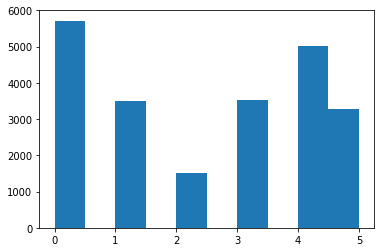

In [56]:
print(df_flav['y'].iloc[good_id].value_counts())

y = df_flav['y'].iloc[good_id]

plt.hist(y)
plt.show()

In [57]:

# Train and validation split 
train_id, val_id, _, _ = train_test_split(good_id, good_id, test_size=0.2, random_state=42, stratify=y)

print('Train', len(train_id))
print('Val',len(val_id))

Train 18039
Val 4510


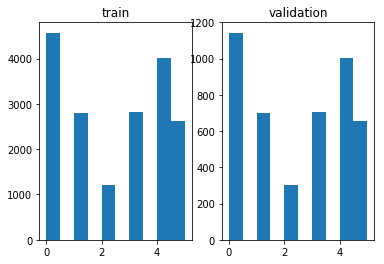

In [58]:
# train and val distibution

plt.subplot(121)
plt.hist(df_flav['y'].iloc[train_id])
plt.title('train')
plt.subplot(122)
plt.hist(df_flav['y'].iloc[val_id])
plt.title('validation')
plt.show()

### Transfer the Images into the Folders

### Bitter --> 0, Meaty --> 1, Piquant --> 2, Salty --> 3, Sour --> 4, Sweet --> 5

In [59]:
def y2label(y):
    if y == 0:
        label = 'Bitter'
    elif y == 1:
        label = 'Meaty'
    elif y == 2:
        label = 'Piquant'
    elif y == 3:
        label = 'Salty'
    elif y == 4:
        label = 'Sour'
    else:
        label = 'Sweet'
    return label

def label2y(label):
    if label == 'Bitter':
        y = 0
    elif label == 'Meaty':
        y = 1
    elif label == 'Piquant':
        y = 2
    elif label == 'Salty':
        y = 3
    elif label == 'Sour':
        y = 4
    else:
        y = 5
    return y


In [60]:
# image folder
img_folder = "images27638/"

# images indexes (name): train_id, val_id


# Transfer the train images
for i in train_id:
    im = str(i+1)
    while len(im) < 5 :
        im = '0' + im
    im ='img' + im + '.jpg'
    fname = im
    
    y_i = df_flav['y'].iloc[i]
    label = y2label(y_i)
    
    # source path to image
    src = os.path.join(img_folder, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Transfer the val images
for i in val_id:
    im = str(i+1)
    while len(im) < 5 :
        im = '0' + im
    im ='img' + im + '.jpg'
    fname = im
    
    y_i = df_flav['y'].iloc[i]
    label = y2label(y_i)
    
    # source path to image
    src = os.path.join(img_folder, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)



NameError: name 'train_dir' is not defined

In [66]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Meaty/')))
print(len(os.listdir('base_dir/train_dir/Sweet/')))
print(len(os.listdir('base_dir/train_dir/Piquant/')))
print(len(os.listdir('base_dir/train_dir/Sour/')))
print(len(os.listdir('base_dir/train_dir/Salty/')))
print(len(os.listdir('base_dir/train_dir/Bitter/')))

4606
4619
4645
4615
4613
4571


In [67]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Meaty/')))
print(len(os.listdir('base_dir/val_dir/Sweet/')))
print(len(os.listdir('base_dir/val_dir/Piquant/')))
print(len(os.listdir('base_dir/val_dir/Sour/')))
print(len(os.listdir('base_dir/val_dir/Salty/')))
print(len(os.listdir('base_dir/val_dir/Bitter/')))

701
655
304
1004
703
1143


### Copy the train images  into aug_dir

In [68]:
# note that we are not augmenting class 'Bitter'
class_list = ['Meaty','Sweet','Piquant','Salty','Sour']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 4600 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 4606 images belonging to 1 classes.
Found 4619 images belonging to 1 classes.
Found 4645 images belonging to 1 classes.
Found 4613 images belonging to 1 classes.
Found 4615 images belonging to 1 classes.


In [69]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/Meaty/')))
print(len(os.listdir('base_dir/train_dir/Sweet/')))
print(len(os.listdir('base_dir/train_dir/Piquant/')))
print(len(os.listdir('base_dir/train_dir/Sour/')))
print(len(os.listdir('base_dir/train_dir/Salty/')))
print(len(os.listdir('base_dir/train_dir/Bitter/')))

4606
4619
4645
4615
4613
4571


### Set Up the Generators

In [70]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(train_id)
num_val_samples = len(val_id)
train_batch_size = 128
val_batch_size = 128
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [71]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 27669 images belonging to 6 classes.
Found 4510 images belonging to 6 classes.
Found 4510 images belonging to 6 classes.


### Modify MobileNet Model

In [72]:
# create a copy of a mobilenet model
mobile = tensorflow.keras.applications.MobileNet(input_shape=(224,224,3))
#mobile = tensorflow.keras.applications.DenseNet169(weights='imagenet',input_shape=(224,224,3))
#mobile = tensorflow.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224,224,3))
#dense_net = tensorflow.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

RuntimeError: Attempted to use a closed Session.

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(6, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

### Train the Model

In [ ]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
    
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=5, verbose=1,
                   callbacks=callbacks_list)


In [35]:
# Best model
model.load_weights(filepath)

### Plot the Training Curves

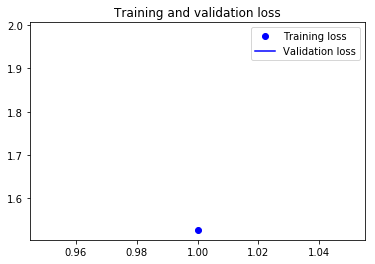

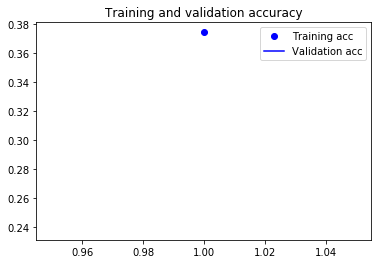

<Figure size 432x288 with 0 Axes>

Best validation accuracy:  0.23813747
On epoch:  1


In [34]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

print('Best validation accuracy: ', np.max(val_acc))
print('On epoch: ', epochs[np.where(val_acc == np.max(val_acc))[0][0]])

### Create a Confusion Matrix

In [ ]:
# from sklearn.metrics import confusion_matrix

# # Get the labels of the test images.

# test_labels = test_batches.classes

In [ ]:
# # We need these to plot the confusion matrix.
# test_labels

In [ ]:
# # Print the label associated with each class
# test_batches.class_indices

In [ ]:
# # make a prediction
# predictions = model.predict_generator(test_batches, steps=len(val_id), verbose=1)

In [ ]:
# predictions.shape

In [ ]:
# # Source: Scikit Learn website
# # http://scikit-learn.org/stable/auto_examples/
# # model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# # selection-plot-confusion-matrix-py


# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()

In [ ]:
# test_labels.shape

In [ ]:
# # argmax returns the index of the max value in a row
# cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# test_batches.class_indices

In [ ]:
# # Define the labels of the class indices. These need to match the 
# # order shown above.
# cm_plot_labels = ['Bitter', 'Meaty', 'Piquant', 'Salty', 'Sour','Sweet']

# plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# # delete temporary directory with the raw image files
# shutil.rmtree('base_dir')

### Test on images

In [ ]:
# # SAVE ENCODED LAYERS FOR LATER VISUALIZATIONS
# # Input the model and a layer to encode, which can be visualized later
# def encoder(model,layer):
#     selection = 'conv_pw_' + str(layer)
#     encoder = Model(inputs=model.input,outputs=model.get_layer(selection).output)
#     #encoder.summary()
#     return(encoder)

In [ ]:
# def plot_pie_chart(model, img, labels):
#     #fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

#     recipe = labels

#     data = model.predict(img)[0]

#     wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

#     bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#     kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
#               bbox=bbox_props, zorder=0, va="center")

#     for i, p in enumerate(wedges):
#         ang = (p.theta2 - p.theta1)/2. + p.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#         connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#         kw["arrowprops"].update({"connectionstyle": connectionstyle})
#         ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                      horizontalalignment=horizontalalignment, **kw)

#     ax.set_title("What AI sees")

In [ ]:
# # creat a useful dictionary structures

# partition = {}
# partition['train'] = train_id
# partition['validation'] = val_id
# partition['faulty'] = faul_id
# partition['no_label'] = nan_id

# labels = {}
# name = {}
# image = {}
# for i in range(27638):
    
#     labels[str(i)] = df_flav.iloc[[i]].values[0] # every label is a panda df rows
    
#     name[str(i)] = df_meta['name'][i]
    
#     im = str(i+1)
#     while len(im) < 5 :
#         im = '0' + im
#     im ='img' + im + '.jpg'
#     image[str(i)] = im

In [ ]:
# num_images = 50
# np.random.seed(42)
# random_images = random.sample(list(nan_id),num_images)

# encoded = encoder(model, 12)



# for i, img_id in enumerate(random_images):
    
#     plt.figure(figsize=(12,12))
#     #dsaodskaod
    
#     #Load in example image
#     im = Image.open("../input/images27638/images27638/"+image[str(img_id)])
#     im = im.resize((224, 224), Image.ANTIALIAS)
#     im.load()
#     im = np.asarray(im, dtype=np.uint8)/255

#     #Plot original image
#     ax = plt.subplot(1, 3, 1)
#     plt.imshow(im)
#     plt.title('Original')
#     im = np.expand_dims(im, axis=0)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
#     #[LORENZO] HERE WE WANT TO VISUALIZE THE ENCODED LAYERS
#     #Plot encoded image ("what the AE sees")
#     ax = plt.subplot(1, 3, 2)
#     encoded_img = encoded.predict(im)
#     #This is still from the autoencoder so we have to reshape differently
#     #To plot the image we need to know the dimension of that layer
#     #This can be found by multiplication e.g. 
#     #conv_pw_12 (Conv2D)  (None, 7, 7, 1024)    = 7*7*1024 = 50,176 dimensions
#     #We need to reshape the image to fit this dimension e.g. 256 x 196 = 50,176 
#     plt.imshow(encoded_img.reshape(256, 196).T)
#     plt.title('Encoded')
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     #Plot decoded image ("what the AE reconstructed")
#     ax = plt.subplot(1, 3, 3)
#     plot_pie_chart(model, im, df_flav.columns)
#     plt.show()

# Visualize layers other approach

In [36]:
def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    input_img_arr,
                    layer_id,
                    filter_id,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(224, 224)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.
    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                              input_im_array,
                              layer_output,
                              filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.expand_dims(np.moveaxis(input_im_array, 2, 0), axis=0)
        else:
            input_img_data = np.expand_dims(input_im_array, axis=0)
            
        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data = input_img_data + (grads_value * step)

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        #print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  #loss_value,
                                                                  #e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        #save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)
        
        plt.imshow(stitched_filters)
        plt.show()

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    # get the name of the desired layer
    for i,layer in enumerate(model.layers):
        if i == layer_id:
            output_layer = layer_dict[layer.name]

    
    assert isinstance(output_layer, layers.Dense)

    processed_filters = []
    
    img_loss = _generate_filter_image(input_img, input_img_arr, output_layer.output, filter_id)

    if img_loss is not None:
        processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

In [37]:
# from tensorflow.keras.models import load_model
# model.save('mobile_yummly.h5')
# #del model
# model_saved = load_model('mobile_yummly.h5')

# model_saved.summary()

In [38]:
# im = Image.open("../input/images27638/images27638/img01993.jpg")
# im = im.resize((224, 224), Image.ANTIALIAS)
# im.load()
            
# X = np.asarray(im)
# X = X.reshape(1,224,224,3)

#plt.imshow(X)
#plt.show()

In [39]:
# visualize_layer(model_saved,X,1,1)

In [40]:
#!pip install keract

In [41]:
# from keract import get_activations
# get_activations(model, X)

# Convert to Protobuf file

In [43]:
import tensorflow as tf

In [44]:
from keras import backend as K
from keras.models import load_model
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

# Set the learning phase to Test since the model is already trained.
K.set_learning_phase(0)

# Load the Keras model
keras_model = tf.keras.models.load_model('model.h5')

# Build the Protocol Buffer SavedModel at 'export_path'
builder = saved_model_builder.SavedModelBuilder('protos')

# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(inputs={"images": keras_model.input},
                                  outputs={"scores": keras_model.output})

with tf.keras.backend.get_session() as sess:
    # Save the meta graph and the variables
    builder.add_meta_graph_and_variables(sess=sess, tags=[tag_constants.SERVING],
                                     signature_def_map={"predict": signature})

builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: protos\saved_model.pb


b'protos\\saved_model.pb'